## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

Set seed for reproducability

In [2]:
seed = 1337
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

## Import and split data

In [3]:
data_path_4 = "../Data/data_air_9400.csv"
df = pd.read_csv(data_path_4, sep=',')


ts_columns = [col for col in df.columns if col.startswith('TS_')]


############# Code for selecting certain frequency bands ############# 
def select_ts_columns(ts_columns):
    selected = []
    for col in ts_columns:
        try:
            # Remove the "TS_" prefix and convert the remainder to float
            freq = float(col.replace("TS_", ""))
        except ValueError:
            continue

        if (36 <= freq <= 45) or (52.5 <= freq <= 87) or (95.5 <= freq <= 156) or (161.5 <= freq <= 258) or (281.5 <= freq <= 380):

            selected.append(col)
            
    return selected

#Filter the columns
ts_columns = select_ts_columns(ts_columns)
print("Using TS columns:", ts_columns)
print("Using this many freqs:", len(ts_columns))


#############################################################################

# Extract features
features = df[ts_columns].values

## Add ro_s as a feature
ro_s_feature = df[['ro_s']].values
features = np.concatenate([features, ro_s_feature], axis=1)

# Only use a, b, and alpha for regression
regression_targets = df[['theta_i_deg', 'a', 'b', 'alpha']].values

# Split data into train, test, validation 80/10/10
X_train, X_temp, reg_train, reg_temp = train_test_split(
    features, regression_targets,
    test_size=0.2, random_state=seed
)
X_val, X_test, reg_val, reg_test = train_test_split(
    X_temp, reg_temp,
    test_size=0.5, random_state=seed, shuffle=False
)

# Normalize features
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

# Normalize regression targets
reg_train_mean = reg_train.mean(axis=0)
reg_train_std = reg_train.std(axis=0)
reg_train = (reg_train - reg_train_mean) / reg_train_std
reg_val = (reg_val - reg_train_mean) / reg_train_std
reg_test = (reg_test - reg_train_mean) / reg_train_std

# Dataset class with optional noise augmentation and transform option
class TSDataset(Dataset):
    def __init__(self, X, reg_y, noise_level=0.0, transform=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.reg_y = torch.tensor(reg_y, dtype=torch.float32)
        self.noise_level = noise_level
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def add_noise(self, x):
        return x + torch.randn_like(x) * self.noise_level
    
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        # Add noise only during training
        if self.noise_level > 0:
            x = self.add_noise(x)
        return x.unsqueeze(0), self.reg_y[idx]

print(len(df))

Using TS columns: ['TS_36.0', 'TS_36.5', 'TS_37.0', 'TS_37.5', 'TS_38.0', 'TS_38.5', 'TS_39.0', 'TS_39.5', 'TS_40.0', 'TS_40.5', 'TS_41.0', 'TS_41.5', 'TS_42.0', 'TS_42.5', 'TS_43.0', 'TS_43.5', 'TS_44.0', 'TS_44.5', 'TS_45.0', 'TS_52.5', 'TS_53.0', 'TS_53.5', 'TS_54.0', 'TS_54.5', 'TS_55.0', 'TS_55.5', 'TS_56.0', 'TS_56.5', 'TS_57.0', 'TS_57.5', 'TS_58.0', 'TS_58.5', 'TS_59.0', 'TS_59.5', 'TS_60.0', 'TS_60.5', 'TS_61.0', 'TS_61.5', 'TS_62.0', 'TS_62.5', 'TS_63.0', 'TS_63.5', 'TS_64.0', 'TS_64.5', 'TS_65.0', 'TS_65.5', 'TS_66.0', 'TS_66.5', 'TS_67.0', 'TS_67.5', 'TS_68.0', 'TS_68.5', 'TS_69.0', 'TS_69.5', 'TS_70.0', 'TS_70.5', 'TS_71.0', 'TS_71.5', 'TS_72.0', 'TS_72.5', 'TS_73.0', 'TS_73.5', 'TS_74.0', 'TS_74.5', 'TS_75.0', 'TS_75.5', 'TS_76.0', 'TS_76.5', 'TS_77.0', 'TS_77.5', 'TS_78.0', 'TS_78.5', 'TS_79.0', 'TS_79.5', 'TS_80.0', 'TS_80.5', 'TS_81.0', 'TS_81.5', 'TS_82.0', 'TS_82.5', 'TS_83.0', 'TS_83.5', 'TS_84.0', 'TS_84.5', 'TS_85.0', 'TS_85.5', 'TS_86.0', 'TS_86.5', 'TS_87.0', 'T

## Convolutional Neural Network

1D Convolutional neural network with residual connections, attention and custom loss function


In [4]:
# Hybrid 1d network with self attention and residual blocks
class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )
        self.last_attention = None

    def forward(self, x):
        b, c, _ = x.shape
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y)
        self.last_attention = y.detach().clone()
        y = y.view(b, c, 1)
        return x * y
    

# Residual Block with option for attention or not
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, use_se=True):
        super().__init__()
        padding = ((kernel_size - 1) // 2) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                              stride=1, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = None
        self.use_se = use_se
        
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
            
        if use_se:
            self.se = SEBlock(out_channels)
    
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        if self.use_se:
            out = self.se(out)
        return self.relu(out)
    
    

class RegressionConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=15, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            ResidualBlock(64, 128, kernel_size=7, dilation=1),
            ResidualBlock(128, 128, kernel_size=5, dilation=2),
            nn.MaxPool1d(2),
            
            ResidualBlock(128, 256, kernel_size=5, dilation=4),
            ResidualBlock(256, 256, kernel_size=3, dilation=8),
            nn.MaxPool1d(2),
            
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(256, 512, kernel_size=1),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        self.flatten = nn.Flatten()
        
        with torch.no_grad():
            dummy = torch.randn(1, 1, 501)
            dummy_out = self.shared_conv(dummy)
            self.flatten_size = dummy_out.numel()
        
        self.angle_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        self.size_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        
    def forward(self, x): 
        features = self.shared_conv(x)
        features = self.flatten(features)
        angle_out = self.angle_layers(features)
        size_out = self.size_layers(features)
        reg_out = torch.cat((angle_out, size_out), dim=1)

        return reg_out
    

Loss function

In [5]:
class RegressionLoss(nn.Module):
    def __init__(self, 
                 consistency_weight=1.0,
                 huber_delta=6.0, 
                 reg_a_mean=0.0, reg_a_std=1.0,
                 reg_b_mean=0.0, reg_b_std=1.0,
                 reg_alpha_mean=0.0, reg_alpha_std=1.0):
        super().__init__()
        self.size_criterion = nn.MSELoss()
        self.consistency_criterion = nn.SmoothL1Loss()
        self.angle_criterion = nn.HuberLoss(delta=huber_delta)
        self.consistency_weight = consistency_weight
        
        # Save normalization parameters for a, b, and alpha
        self.reg_a_mean = reg_a_mean
        self.reg_a_std = reg_a_std
        self.reg_b_mean = reg_b_mean
        self.reg_b_std = reg_b_std
        self.reg_alpha_mean = reg_alpha_mean
        self.reg_alpha_std = reg_alpha_std

    def forward(self, regression_pred, regression_target):
        
        theta_pred = regression_pred[:, 0]
        a_pred = regression_pred[:, 1]
        b_pred = regression_pred[:, 2]

        theta_true = regression_target[:, 0]
        a_true = regression_target[:, 1]
        b_true = regression_target[:, 2]
        alpha_true = regression_target[:, 3]
        
        
        theta_loss = self.angle_criterion(theta_pred, theta_true)
        a_loss = self.size_criterion(a_pred, a_true)
        b_loss = self.size_criterion(b_pred, b_true)
        
        
        epsilon = 0
        a_pred_orig = a_pred * self.reg_a_std + self.reg_a_mean
        b_pred_orig = b_pred * self.reg_b_std + self.reg_b_mean
        predicted_alpha_orig = a_pred_orig / (b_pred_orig + epsilon)
        
        # Denormalize alpha
        alpha_true_orig = alpha_true * self.reg_alpha_std + self.reg_alpha_mean
        
        # Consistency loss compare predicted alpha to true alpha
        consistency_loss = self.consistency_criterion(predicted_alpha_orig, alpha_true_orig)
        
        # Total regression loss sum the losses, including the weighted consistency loss
        regression_loss = theta_loss + a_loss + b_loss + (self.consistency_weight * consistency_loss)

        return regression_loss


## Training model

Early stopping

In [6]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=2, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

Hyperparameters and other variables

In [7]:
# Variables
#model_path = '../Models/improved_angle_model_struct_jup_reg_4_ro_s_small.pth'
model_path = '../Models/in_situ_simulated_air_10_380_new_ang_grid_s.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


Noise augmented spectra

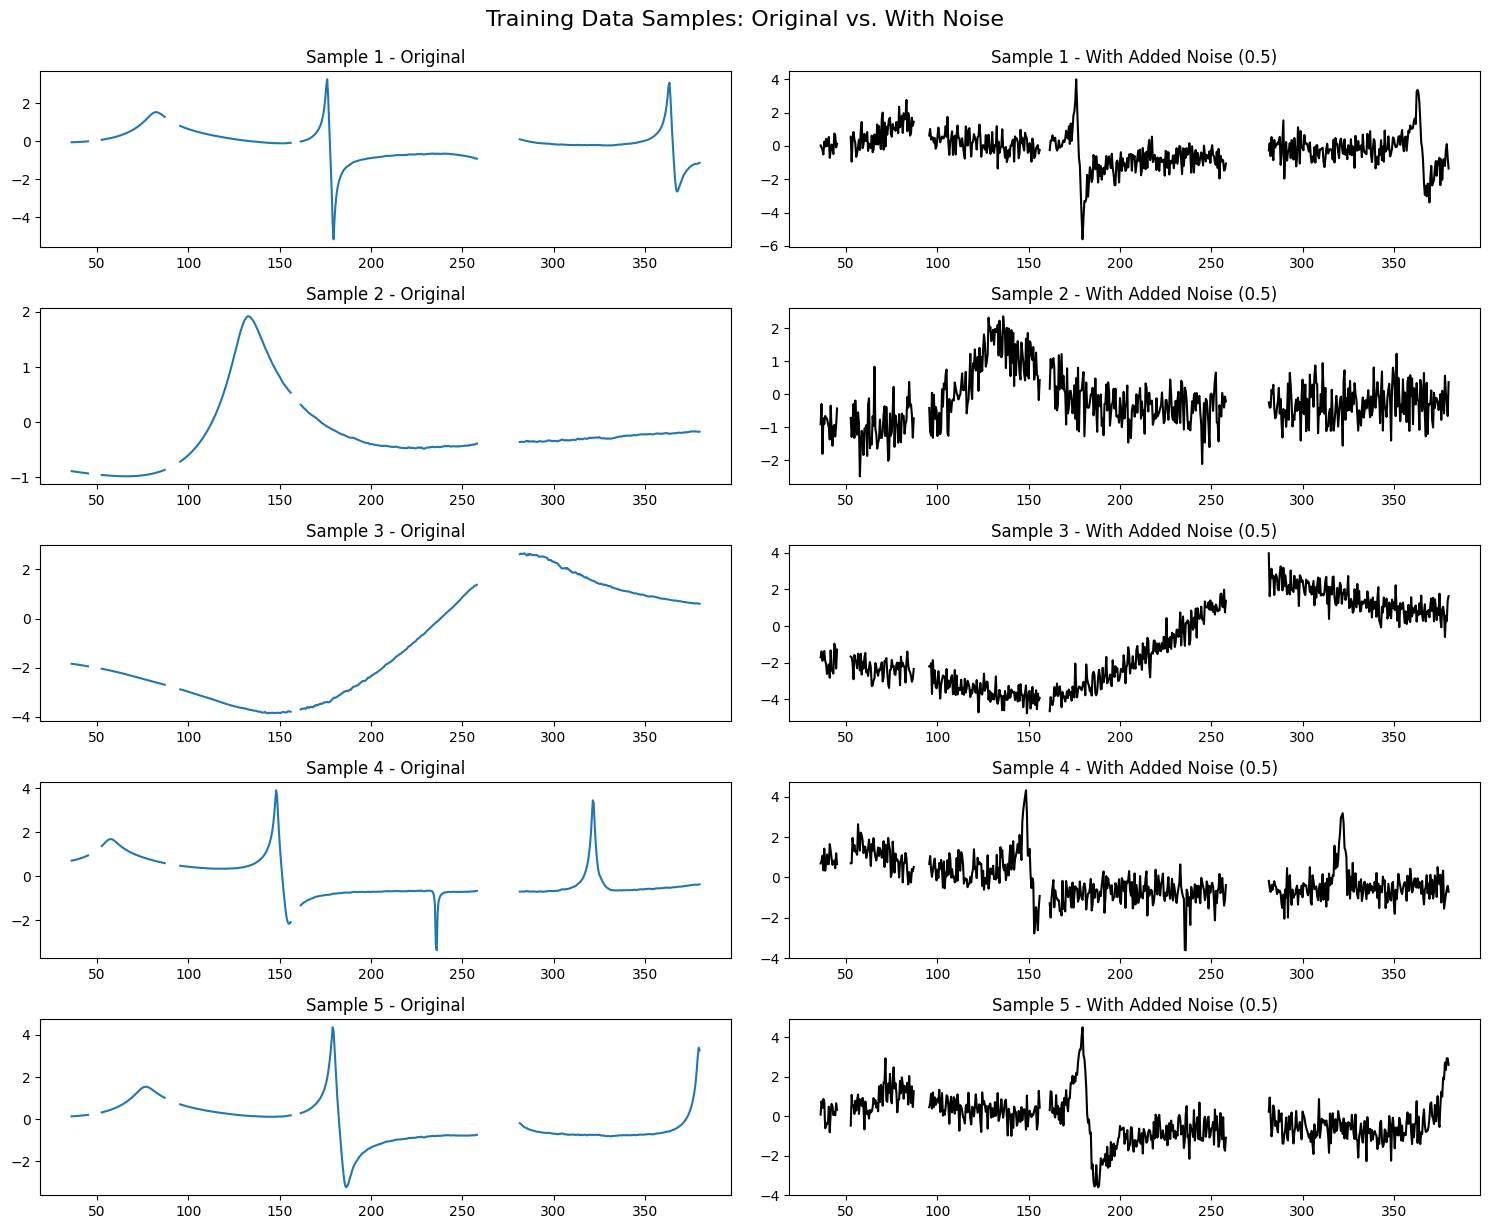

In [8]:
# Plot a few samples from the training data with and without noise
frequencies = [float(col.replace('TS_', '')) for col in ts_columns]

# Find the gaps
gaps = []
for i in range(1, len(frequencies)):
    if frequencies[i] - frequencies[i-1] > 0.5:
        gaps.append((frequencies[i-1], frequencies[i]))

# dataset with noise and  without
train_dataset_no_noise = TSDataset(X_train[:5], reg_train[:5], noise_level=0)
train_dataset_with_noise = TSDataset(X_train[:5], reg_train[:5], noise_level=0.5)

# Plot 5 samples from training
fig, axs = plt.subplots(5, 2, figsize=(15, 12))
for i in range(5):
    x_orig, _ = train_dataset_no_noise[i]
    ts_data_orig = x_orig.squeeze(0).numpy()[:-1]
    
    sorted_indices = np.argsort(frequencies)
    sorted_freqs = np.array(frequencies)[sorted_indices]
    sorted_data_orig = ts_data_orig[sorted_indices]
    
    regions = []
    start_idx = 0
    for gap_start, gap_end in gaps:
        end_idx = np.searchsorted(sorted_freqs, gap_start, side='right')
        regions.append((start_idx, end_idx))
        start_idx = np.searchsorted(sorted_freqs, gap_end, side='left')
   
    regions.append((start_idx, len(sorted_freqs)))
    
    for start_idx, end_idx in regions:
        axs[i, 0].plot(sorted_freqs[start_idx:end_idx], sorted_data_orig[start_idx:end_idx], '-', color='#1f77b4')
    
    axs[i, 0].set_title(f'Sample {i+1} - Original')
    
    x_noisy, _ = train_dataset_with_noise[i]
    ts_data_noisy = x_noisy.squeeze(0).numpy()[:-1] 
    
    sorted_data_noisy = ts_data_noisy[sorted_indices]
    
    for start_idx, end_idx in regions:
        axs[i, 1].plot(sorted_freqs[start_idx:end_idx], sorted_data_noisy[start_idx:end_idx], '-', color='black')
    
    axs[i, 1].set_title(f'Sample {i+1} - With Added Noise (0.5)')

plt.tight_layout()
plt.suptitle('Training Data Samples: Original vs. With Noise', y=1.02, fontsize=16)
plt.show()

Hyperparameter search \
Uncomment to run gridsearch, results are saved in the grid_search folder

In [9]:
# from sklearn.model_selection import ParameterGrid
# import copy
# import time

# # Training function for pure regression
# def train_epoch(model, train_loader, criterion, optimizer, device, scheduler):
#     model.train()
#     total_loss = 0
    
#     for inputs, reg_targets in train_loader:
#         inputs = inputs.to(device)
#         reg_targets = reg_targets.to(device)
        
#         optimizer.zero_grad()
#         reg_outputs = model(inputs)
        
#         loss = criterion(reg_outputs, reg_targets)
        
#         loss.backward()
        
#         # Gradient clipping to prevent exploding gradients
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         scheduler.step()
        
#         total_loss += loss.item() * inputs.size(0)
    
#     return total_loss / len(train_loader.dataset)

# # Evaluation function for hyperparemeter tuning on best composite score
# def evaluate_hyperparam_tune(model, test_loader, criterion, device, denorm=True):
#     model.eval()
#     total_loss = 0
#     all_outputs = []
#     all_targets = []
    
#     with torch.no_grad():
#         for inputs, reg_targets in test_loader:
#             inputs = inputs.to(device)
#             reg_targets = reg_targets.to(device)
            
#             reg_outputs = model(inputs)
#             loss = criterion(reg_outputs, reg_targets)
            
#             total_loss += loss.item() * inputs.size(0)
            
#             # Store outputs and targets for R2 calculation
#             all_outputs.append(reg_outputs.cpu().numpy())
#             all_targets.append(reg_targets.cpu().numpy())
    
#     avg_loss = total_loss / len(test_loader.dataset)
    
#     all_outputs = np.vstack(all_outputs)
#     all_targets = np.vstack(all_targets)
    

#     if denorm:
#         all_outputs = all_outputs[:, :3] * reg_train_std[:3] + reg_train_mean[:3]
#         all_targets = all_targets[:, :3] * reg_train_std[:3] + reg_train_mean[:3]
    
#     r2_scores = []
#     for i in range(3):  # theta, a, b
#         r2 = r2_score(all_targets[:, i], all_outputs[:, i])
#         r2_scores.append(r2)
    
#     #calculate composite score
#     composite_score = sum(r2_scores) / 3
    
#     return avg_loss, composite_score, r2_scores



# #Grid
# param_grid = {
#     'batch_size': [64, 128],
#     'learning_rate': [0.001, 0.0005],
#     'consistency_weight': [0.5, 1.0],
#     'huber_delta': [5.0, 7.0],
#     'T_0': [2, 3, 5], 
#     'T_mult': [2, 3], 
#     'eta_min': [1e-7, 1e-8]

# }

# # Create all combinations from grid
# grid = list(ParameterGrid(param_grid))
# print(f"Total number of combinations: {len(grid)}")

# grid_results = []

# #Grid search loop
# for params in grid:
#     start_time = time.time()
#     print(f"\nTesting parameters: {params}")
    
#     #hyperparameters from grid
#     batch_size = params['batch_size']
#     l_rate = params['learning_rate']
#     consistency_weight = params['consistency_weight']
#     h_delt = params['huber_delta']
#     Tt_0 = params['T_0']
#     T_mult = params['T_mult']
#     eta_min = params['eta_min']
    
#     train_dataset = TSDataset(X_train, reg_train, noise_level=0.5)
#     val_dataset = TSDataset(X_val, reg_val, noise_level=0)
    
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
#     model = RegressionConvNet().to(device)
    
#     optimizer = optim.Adam(model.parameters(), lr=l_rate, weight_decay=2e-4)
    
#     criterion = RegressionLoss(
#         huber_delta=h_delt,
#         consistency_weight=consistency_weight,
#         reg_a_mean=reg_train_mean[1],
#         reg_a_std=reg_train_std[1],
#         reg_b_mean=reg_train_mean[2],
#         reg_b_std=reg_train_std[2],
#         reg_alpha_mean=reg_train_mean[3],
#         reg_alpha_std=reg_train_std[3]
#     )
    
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=Tt_0, T_mult=T_mult, eta_min=eta_min)
    
#     # Keep early stopping based on loss
#     early_stopping = EarlyStopping(patience=20)
#     # Training loop
#     best_val_loss = float('inf')
#     best_val_score = float('-inf')
#     best_r2_scores = None
#     train_losses = []
#     val_losses = []
#     val_scores = []
    
#     for epoch in range(50):
#         train_loss = train_epoch(model, train_loader, criterion, optimizer, device, scheduler)
#         val_loss, val_score, r2_scores = evaluate_hyperparam_tune(model, val_loader, criterion, device)
        
#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         val_scores.append(val_score)
        
#         # Track both best loss (for early stopping) and best score (for model selection)
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             # Save model if it has the best loss
#             best_loss_model_state = copy.deepcopy(model.state_dict())
            
#         # Also track best score separately
#         if val_score > best_val_score:
#             best_val_score = val_score
#             best_r2_scores = r2_scores
#             # Save model if it has the composite best score
#             best_score_model_state = copy.deepcopy(model.state_dict())
        
#         if early_stopping(val_loss):
#             print(f"Early stopping at epoch {epoch+1}")
#             break
        
#         print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2 Score: {val_score:.4f}')
    
#     elapsed_time = time.time() - start_time
#     grid_results.append({
#         'params': params,
#         'best_val_loss': best_val_loss,
#         'best_val_score': best_val_score,
#         'best_r2_scores': best_r2_scores,
#         'epochs': len(train_losses),
#         'time': elapsed_time
#     })
    
#     print(f"Finished in {elapsed_time:.2f}s. Best loss: {best_val_loss:.4f}, Best R2 score: {best_val_score:.4f}")
#     print(f"Individual R2 scores - theta: {best_r2_scores[0]:.4f}, a: {best_r2_scores[1]:.4f}, b: {best_r2_scores[2]:.4f}")

# # Sort results
# grid_results.sort(key=lambda x: x['best_val_score'], reverse=True)

# # Print top 5 results
# print("\nTop 5 parameter combinations (by R2 score):")
# for i, result in enumerate(grid_results[:5]):
#     r2s = result['best_r2_scores']
#     print(f"{i+1}. Composite R2: {result['best_val_score']:.4f}, Loss: {result['best_val_loss']:.4f}, " 
#           f"R2 (θ,a,b): ({r2s[0]:.4f}, {r2s[1]:.4f}, {r2s[2]:.4f}), Params: {result['params']}")

# best_params = grid_results[0]['params']
# print(f"\nBest Parameters (by R2 score): {best_params}")

# # Set the best parameters for final training
# batch_size = best_params['batch_size']
# l_rate = best_params['learning_rate']
# h_delt = best_params['huber_delta']
# Tt_0 = best_params['T_0']
# T_mult = best_params['T_mult']
# eta_min = best_params['eta_min']
# consistency_weight = best_params['consistency_weight']


# #### Saves the gridsearch results in descending order to a csv ###
# results_data = []
# for i, result in enumerate(grid_results):
#     result_dict = {
#         'rank': i + 1,
#         'batch_size': result['params']['batch_size'],
#         'learning_rate': result['params']['learning_rate'],
#         'consistency_weight': result['params']['consistency_weight'],
#         'huber_delta': result['params']['huber_delta'],
#         'T_0': result['params']['T_0'],
#         'T_mult': result['params']['T_mult'],
#         'eta_min': result['params']['eta_min'],
#         'composite_r2': result['best_val_score'],
#         'val_loss': result['best_val_loss'],
#         'r2_theta': result['best_r2_scores'][0],
#         'r2_a': result['best_r2_scores'][1],
#         'r2_b': result['best_r2_scores'][2],
#         'epochs': result['epochs'],
#         'time_seconds': result['time']
#     }
#     results_data.append(result_dict)

# results_df = pd.DataFrame(results_data)

# csv_filename = f"../grid_search/grid_search_results_experiment2.csv"
# results_df.to_csv(csv_filename, index=False)
# print(f"Grid search results also saved as CSV to {csv_filename}")



Dataloaders and model Initialization

In [10]:

best_parameters = {'T_0': 3,'T_mult': 2,'batch_size': 128,
                    'consistency_weight': 0.5, 'eta_min': 1e-07,
                    'huber_delta': 5.0, 'learning_rate': 0.001}

batch_size = best_parameters['batch_size']
l_rate = best_parameters['learning_rate']
h_delt = best_parameters['huber_delta']
Tt_0 = best_parameters['T_0']
T_mult = best_parameters['T_mult']
eta_min = best_parameters['eta_min']
consistency_weight = best_parameters['consistency_weight']

n_epochs = 100

train_dataset = TSDataset(X_train, reg_train, noise_level=0.5)
val_dataset = TSDataset(X_val, reg_val, noise_level=0)
test_dataset = TSDataset(X_test, reg_test, noise_level=0)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


model = RegressionConvNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=l_rate, weight_decay=2e-4)

criterion = RegressionLoss(
    huber_delta=h_delt,
    consistency_weight=consistency_weight,
    reg_a_mean=reg_train_mean[1],
    reg_a_std=reg_train_std[1],
    reg_b_mean=reg_train_mean[2],
    reg_b_std=reg_train_std[2],
    reg_alpha_mean=reg_train_mean[3],
    reg_alpha_std=reg_train_std[3]
)

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=Tt_0, T_mult=T_mult, eta_min=eta_min)

early_stopping = EarlyStopping(patience=30)


Load model

In [ ]:
# Used to load model to skip training
# Uncomment and skip next code cell (Training cell) to use

model.load_state_dict(torch.load(model_path, map_location=device))

C:\Users\sande\AppData\Local\Temp\ipykernel_24864\2746019817.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

Training loop with training and validaition loss history plot

In [12]:
# # Training function
# # Uncomment to train model again
# def train_epoch(model, train_loader, criterion, optimizer, device, scheduler):
#     model.train()
#     total_loss = 0
    
#     for inputs, reg_targets in train_loader:
#         inputs = inputs.to(device)
#         reg_targets = reg_targets.to(device)
        
#         optimizer.zero_grad()
#         reg_outputs = model(inputs)
        
#         loss = criterion(reg_outputs, reg_targets)
        
#         loss.backward()
        
#         # Gradient clipping to prevent exploding gradients
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
#         scheduler.step()
        
#         total_loss += loss.item() * inputs.size(0)
    
#     return total_loss / len(train_loader.dataset)

# def evaluate(model, test_loader, criterion, device):
#     model.eval()
#     total_loss = 0
    
#     with torch.no_grad():
#         for inputs, reg_targets in test_loader:
#             inputs = inputs.to(device)
#             reg_targets = reg_targets.to(device)
            
#             reg_outputs = model(inputs)
#             loss = criterion(reg_outputs, reg_targets)
            
#             total_loss += loss.item() * inputs.size(0)
    
#     avg_loss = total_loss / len(test_loader.dataset)
    
#     return avg_loss

# # Training loop
# best_val_loss = float('inf')
# train_losses = []
# val_losses = []

# for epoch in range(n_epochs):
#     train_loss = train_epoch(model, train_loader, criterion, optimizer, device, scheduler)
#     val_loss = evaluate(model, val_loader, criterion, device)
    
#     # Saves the model with lowest validation loss
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), model_path)
    
#     if early_stopping(val_loss):
#         print(f"Early stopping triggered, best loss: {best_val_loss:.4f}")
#         break

#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# # Plot training history
# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, label="Training Loss")
# plt.plot(val_losses, label="Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

## Model evaluation

C:\Users\sande\AppData\Local\Temp\ipykernel_24864\1308894677.py:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Regression Results:
--------------------------------------------------

Metrics for Angle (θ) [°]:
RMSE: 10.8961
R² Score: 0.8201

Metrics for Semi-Major axis (a) [mm]:
RMSE: 0.0000
R² Score: 0.9890

Metrics for Semi-Minor axis (b) [mm]:
RMSE: 0.0000
R² Score: 0.9936

Metrics for Aspect ratio (α):
RMSE: 0.3368
R² Score: 0.9703


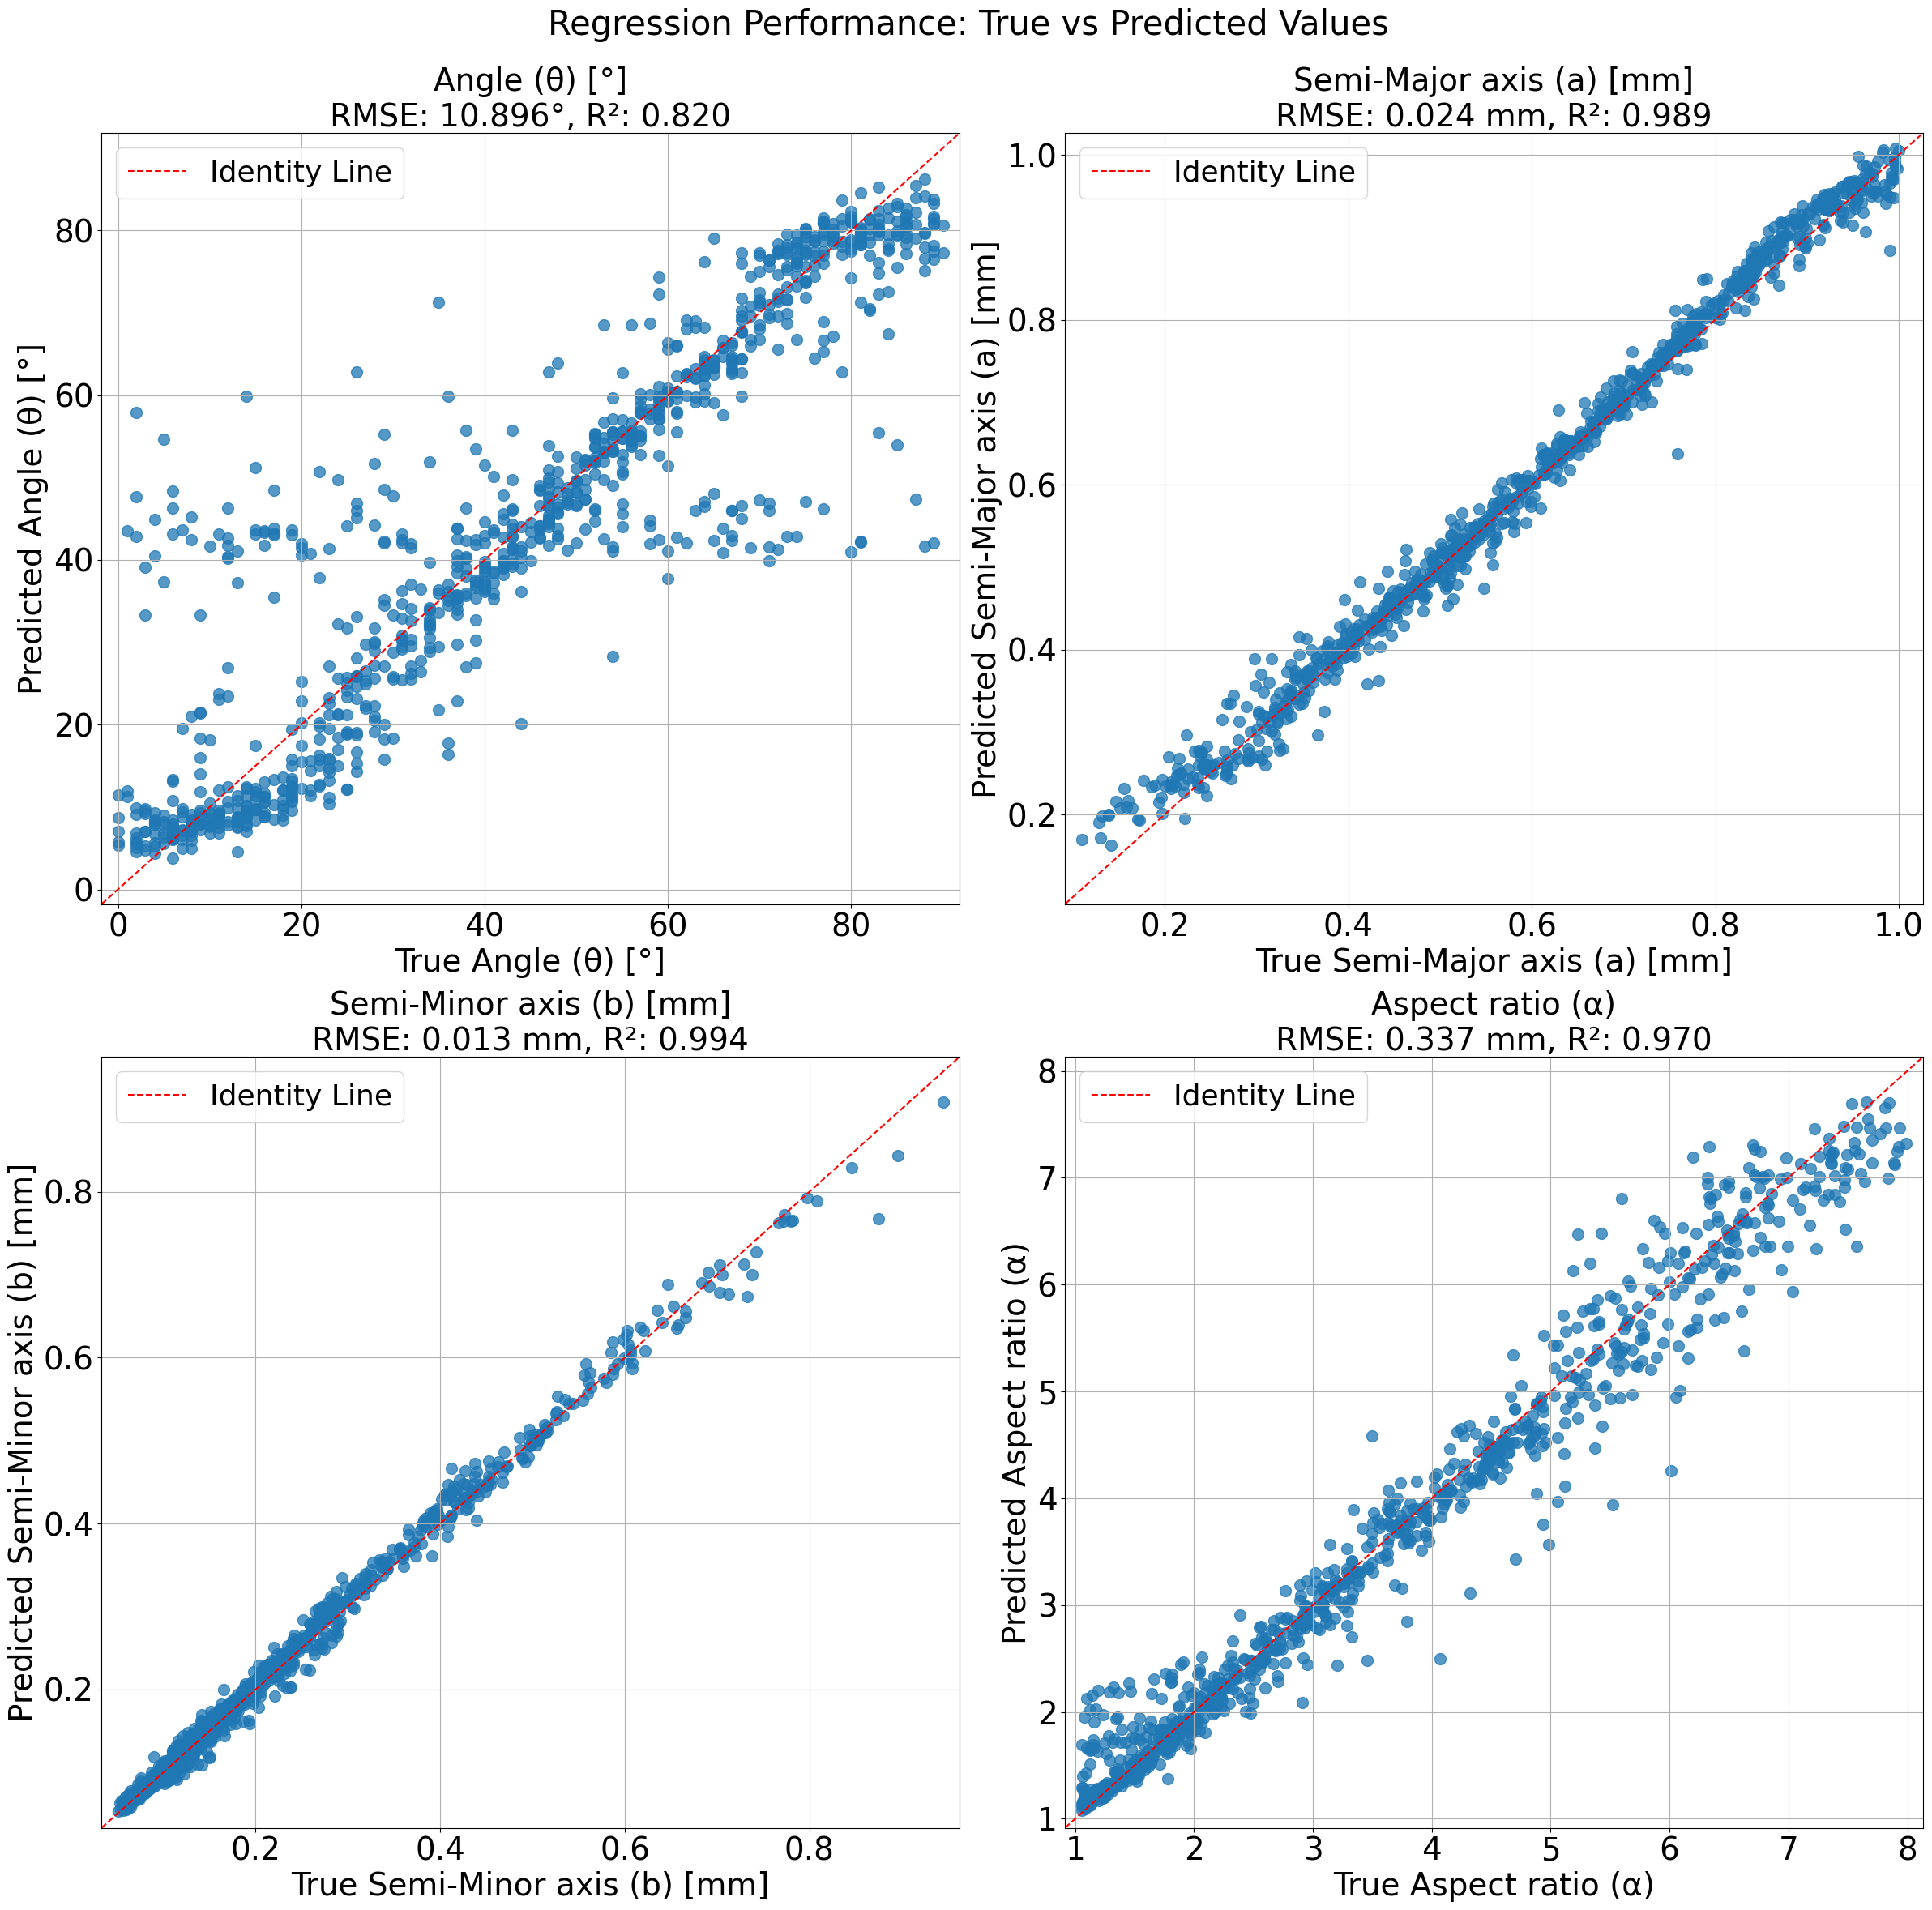

In [13]:
def evaluate_predictions(model, data_loader, device, reg_train_mean, reg_train_std):
    model.eval()
    all_reg_preds = []
    all_reg_true = []
    
    with torch.no_grad():
        for inputs, reg_targets in data_loader:
            inputs = inputs.to(device)
            reg_outputs = model(inputs)
            
            all_reg_preds.extend(reg_outputs.cpu().numpy())
            all_reg_true.extend(reg_targets.numpy())
    
    # Convert lists to arrays
    all_reg_preds = np.array(all_reg_preds)
    all_reg_true = np.array(all_reg_true)
    
    # Denormalize regression values
    denorm_preds = all_reg_preds * reg_train_std[:3] + reg_train_mean[:3]
    denorm_true = all_reg_true * reg_train_std + reg_train_mean
    

    a_pred = denorm_preds[:, 1] 
    b_pred = denorm_preds[:, 2]
    computed_alpha_pred = a_pred / b_pred
    

    true_alpha = denorm_true[:, 3]
    
    # Regression metrics
    print("\nRegression Results:")
    print("-" * 50)
    
    fig, axes = plt.subplots(2, 2, figsize=(24, 24))
    axes = axes.flatten()
    
    plt.subplots_adjust(hspace=0.45)
    
    # Define parameter names
    reg_names = ['theta_i_deg', 'a', 'b', 'alpha']
    display_names = ['Angle (θ) [°]', 'Semi-Major axis (a) [mm]', 'Semi-Minor axis (b) [mm]', 'Aspect ratio (α)']
    
    for i, (ax, reg_name, display_name) in enumerate(zip(axes, reg_names, display_names)):
        if i < 3: 
            true_values = denorm_true[:, i]
            pred_values = denorm_preds[:, i]
        else: #For alpha
            true_values = true_alpha
            pred_values = computed_alpha_pred
        
        mse = mean_squared_error(true_values, pred_values)
        rmse = np.sqrt(mse)
        r2 = r2_score(true_values, pred_values)
        
        print(f"\nMetrics for {display_name}:")
        print(f"RMSE: {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")
        
        ax.scatter(
            true_values, 
            pred_values, 
            alpha=0.75, 
            color='tab:blue', 
            s=100 
        )
        
        # Add identity line
        min_val = min(true_values.min(), pred_values.min())
        max_val = max(true_values.max(), pred_values.max())
        
        buffer = (max_val - min_val) * 0.02
        min_plot = min_val - buffer
        max_plot = max_val + buffer

        ax.set_xlim(min_plot, max_plot)
        ax.set_ylim(min_plot, max_plot)
        ax.plot([min_plot, max_plot], [min_plot, max_plot], 'r--', label='Identity Line')
        

        # Format tick labels for a and b to show in millimeters
        if i == 1 or i == 2: 
            x_ticks = ax.get_xticks()
            y_ticks = ax.get_yticks()
            
            x_ticks = x_ticks[(x_ticks >= min_plot) & (x_ticks <= max_plot)]
            y_ticks = y_ticks[(y_ticks >= min_plot) & (y_ticks <= max_plot)]
            
            #tick labels in mm
            x_tick_labels = [f'{x*1000:.1f}' for x in x_ticks]
            y_tick_labels = [f'{y*1000:.1f}' for y in y_ticks]
            
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_tick_labels, fontsize=28)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_tick_labels, fontsize=28)


        ax.set_xlabel(f'True {display_name}', fontsize=28)
        ax.set_ylabel(f'Predicted {display_name}', fontsize=28)
        
        # Convert error to mm
        if i == 0 :
            ax.set_title(f'{display_name}\nRMSE: {rmse:.3f}°, R²: {r2:.3f}', fontsize=28)
        elif i == 1 or i == 2:
            ax.set_title(f'{display_name}\nRMSE: {rmse*1000:.3f} mm, R²: {r2:.3f}', fontsize=28)
        else:
            ax.set_title(f'{display_name}\nRMSE: {rmse:.3f} mm, R²: {r2:.3f}', fontsize=28)
        
        

        ax.tick_params(axis='both', which='major', labelsize=28)
        ax.legend(fontsize=26)
        ax.grid(True)
    

    fig.suptitle('Regression Performance: True vs Predicted Values', fontsize=30)
    

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    # Save the figure
    plt.savefig('../Figures/regression_results_experiment2_low.png', dpi=100, bbox_inches='tight')
    plt.savefig('../Figures/regression_results_experiment2.png', dpi=600, bbox_inches='tight')
    plt.show()
    
model.load_state_dict(torch.load(model_path, map_location=device))
evaluate_predictions(model, test_loader, device, reg_train_mean, reg_train_std)

Test against in situ data.

In [17]:
def predict_tar(tar):
    new_data_path = f"..\\in_situ_data\\merged_TS_Target_{tar}.csv"
    df_new = pd.read_csv(new_data_path)

    available_ts_columns = [col for col in ts_columns if col in df_new.columns]
    if len(available_ts_columns) != len(ts_columns):
        print(f"Warning: Only {len(available_ts_columns)} out of {len(ts_columns)} TS columns found in new data")
    
    df_ts = df_new[available_ts_columns]
    
    ro_s_feature = df_new[['ro_s']].values
    features_new = df_ts.values 
    features_new = np.concatenate([features_new, ro_s_feature], axis=1)
    
    features_new_norm = (features_new - X_train_mean) / X_train_std

    input_tensor = torch.tensor(features_new_norm, dtype=torch.float32).unsqueeze(1).to(device)

    #Get predictions from the model
    model.eval()
    with torch.no_grad():
        reg_out = model(input_tensor)
        reg_preds = reg_out.cpu().numpy()
        
        #Denormalize the predictions
        reg_preds_denorm = reg_preds * reg_train_std[:3] + reg_train_mean[:3]


    theta = reg_preds_denorm[0, 0]
    a = reg_preds_denorm[0, 1]
    b = reg_preds_denorm[0, 2]
    
    #Calculate derived parameters aspect ratio and radius in mm
    alpha = a / b
    equiv_radius_mm = (b * np.cbrt(alpha)) * 1000 

    #Print the results
    print(f"Predicted results for target {tar}:")
    print(f"  Incident angle (theta_i): {theta:.2f} degrees")
    print(f"  a: {a:.6f}")
    print(f"  b: {b:.6f}")
    print(f"  Aspect ratio (a/b): {alpha:.6f}")
    print(f"  Estimated equivalent radius: {equiv_radius_mm:.3f} mm")
    print()


In [16]:
print("FOR STATION 171")

t_171 = [1,2,8,9]

for i in t_171:
    predict_tar(i)

FOR STATION 171
New data shape: (1, 604)
Predicted results for target 1:
  Incident angle (theta_i): 36.55 degrees
  a: 0.000539
  b: 0.000141
  Aspect ratio (a/b): 3.825494
  Estimated equivalent radius: 0.220 mm

New data shape: (1, 604)
Predicted results for target 2:
  Incident angle (theta_i): 67.23 degrees
  a: 0.000694
  b: 0.000415
  Aspect ratio (a/b): 1.674660
  Estimated equivalent radius: 0.492 mm

New data shape: (1, 604)
Predicted results for target 8:
  Incident angle (theta_i): 56.06 degrees
  a: 0.000811
  b: 0.000359
  Aspect ratio (a/b): 2.256012
  Estimated equivalent radius: 0.471 mm

New data shape: (1, 604)
Predicted results for target 9:
  Incident angle (theta_i): 84.09 degrees
  a: 0.001009
  b: 0.000245
  Aspect ratio (a/b): 4.124722
  Estimated equivalent radius: 0.392 mm



In [17]:
print("FOR STATION 178")

t_178 =[3,4,5,6,7]

for j in t_178:
    predict_tar(j)

FOR STATION 178
New data shape: (1, 604)
Predicted results for target 3:
  Incident angle (theta_i): 61.21 degrees
  a: 0.000870
  b: 0.000201
  Aspect ratio (a/b): 4.322513
  Estimated equivalent radius: 0.328 mm

New data shape: (1, 604)
Predicted results for target 4:
  Incident angle (theta_i): 41.16 degrees
  a: 0.000535
  b: 0.000171
  Aspect ratio (a/b): 3.126121
  Estimated equivalent radius: 0.250 mm

New data shape: (1, 604)
Predicted results for target 5:
  Incident angle (theta_i): 54.68 degrees
  a: 0.000556
  b: 0.000143
  Aspect ratio (a/b): 3.881757
  Estimated equivalent radius: 0.225 mm

New data shape: (1, 604)
Predicted results for target 6:
  Incident angle (theta_i): 62.17 degrees
  a: 0.000758
  b: 0.000320
  Aspect ratio (a/b): 2.364090
  Estimated equivalent radius: 0.427 mm

New data shape: (1, 604)
Predicted results for target 7:
  Incident angle (theta_i): 37.43 degrees
  a: 0.000596
  b: 0.000202
  Aspect ratio (a/b): 2.942382
  Estimated equivalent radius:

In [18]:
print("For unknown targets")
t_11_12 =[10, 11,12]

for k in t_11_12:
    predict_tar(k)

For unknown targets
New data shape: (1, 604)
Predicted results for target 10:
  Incident angle (theta_i): 71.92 degrees
  a: 0.000894
  b: 0.000397
  Aspect ratio (a/b): 2.251851
  Estimated equivalent radius: 0.520 mm

New data shape: (1, 604)
Predicted results for target 11:
  Incident angle (theta_i): 82.30 degrees
  a: 0.000937
  b: 0.000660
  Aspect ratio (a/b): 1.419128
  Estimated equivalent radius: 0.742 mm

New data shape: (1, 604)
Predicted results for target 12:
  Incident angle (theta_i): 78.77 degrees
  a: 0.000935
  b: 0.000541
  Aspect ratio (a/b): 1.726773
  Estimated equivalent radius: 0.649 mm

